In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import csv

import contractions
import nltk
from nltk.text import Text
from nltk.corpus import PlaintextCorpusReader
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import re 

In [2]:
df = pd.read_csv('washington_normal_2020.csv')

In [3]:
df

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe
0,https://twitter.com/TeeJ_Apple/status/13447910...,2020-12-31 23:42:28+00:00,well lost weight ate healthy fail though came ...,well lost weight ate healthy fail though came ...,1344791061986762753,https://twitter.com/TeeJ_Apple,1,0,1,0,...,NaN,NaN,NaN,"Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN
1,https://twitter.com/MattyCj22/status/134478368...,2020-12-31 23:13:10+00:00,covid took legend rest power,covid took legend rest power,1344783686659678210,https://twitter.com/MattyCj22,0,0,1,0,...,NaN,NaN,NaN,"Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN
2,https://twitter.com/aikers99/status/1344779663...,2020-12-31 22:57:11+00:00,realdonaldtrump december country plunged would...,realdonaldtrump december country plunged would...,1344779663852367873,https://twitter.com/aikers99,0,0,0,0,...,1.344718e+18,https://twitter.com/realDonaldTrump,"[User(username='realDonaldTrump', id=25073877,...","Coordinates(longitude=-77.335163, latitude=38....","Place(id='e4aee3ab11ef52a6', fullName='Fairfax...",NaN,NaN,NaN,NaN,NaN
3,https://twitter.com/noramurray/status/13447759...,2020-12-31 22:42:31+00:00,seems hard celebrate ending difficult year peo...,seems hard celebrate ending difficult year peo...,1344775974668423168,https://twitter.com/noramurray,0,0,3,0,...,NaN,NaN,NaN,"Coordinates(longitude=-79.487651, latitude=37....","Place(id='dea1eac2d7ef8878', fullName='Marylan...",NaN,NaN,NaN,NaN,NaN
4,https://twitter.com/laurvanhasselt/status/1344...,2020-12-31 22:36:59+00:00,lmfaoooo covid b like,lmfaoooo covid b like,1344774581995896837,https://twitter.com/laurvanhasselt,1,0,0,0,...,1.344771e+18,https://twitter.com/ChillWill63,"[User(username='ChillWill63', id=2919643282, d...","Coordinates(longitude=-79.487651, latitude=37....","Place(id='dea1eac2d7ef8878', fullName='Marylan...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29584,https://twitter.com/futuretwunk/status/1256034...,2020-05-01 01:33:55+00:00,coronavirus may cancelled sport still playing ...,coronavirus may cancelled sport still playing ...,1256034079197270019,https://twitter.com/futuretwunk,0,0,2,0,...,NaN,NaN,NaN,"Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN
29585,https://twitter.com/aclater/status/12560292728...,2020-05-01 01:14:49+00:00,new york post maryland gov larry hogan nationa...,new york post maryland gov larry hogan nationa...,1256029272801714176,https://twitter.com/aclater,0,0,1,0,...,NaN,NaN,"[User(username='googlenews', id=33584794, disp...","Coordinates(longitude=-77.327307, latitude=38....","Place(id='4769ebcaeee50421', fullName='Burke, ...",NaN,NaN,NaN,NaN,NaN
29586,https://twitter.com/africa_mavia/status/125601...,2020-05-01 00:35:24+00:00,essential activites got people outside normall...,essential activites got people outside normall...,1256019355323764738,https://twitter.com/africa_mavia,0,0,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",['coronavirus'],NaN,NaN,NaN,NaN
29587,https://twitter.com/RickHammerly/status/125601...,2020-05-01 00:17:57+00:00,trump completely inept coronavirus response fo...,trump completely inept coronavirus response fo...,1256014964822880258,https://twitter.com/RickHammerly,0,0,0,0,...,NaN,NaN,"[User(username='NPR', id=5392522, displayname=...","Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN


In [4]:
df.isna().sum()

url                     0
date                    0
rawContent             22
renderedContent        22
id                      0
user                    0
replyCount              0
retweetCount            0
likeCount               0
quoteCount              0
conversationId          0
lang                    0
source                  0
sourceUrl               0
sourceLabel             0
links               21360
media               25381
retweetedTweet      29589
quotedTweet         25018
inReplyToTweetId    21833
inReplyToUser       21833
mentionedUsers      16742
coordinates             5
place                   1
hashtags            21466
cashtags            29569
card                26300
viewCount           29589
vibe                29589
dtype: int64

In [3]:
df['rawContent'].fillna('', inplace=True)
df['renderedContent'].fillna('', inplace=True)

In [4]:
## remove specific word HTTP
df['rawContent'] = df['rawContent'].str.replace('covid', '')
df['rawContent'] = df['rawContent'].str.replace('coronavirus', '')

df['renderedContent'] = df['renderedContent'].str.replace('covid', '')
df['renderedContent'] = df['renderedContent'].str.replace('coronavirus', '')

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 10)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

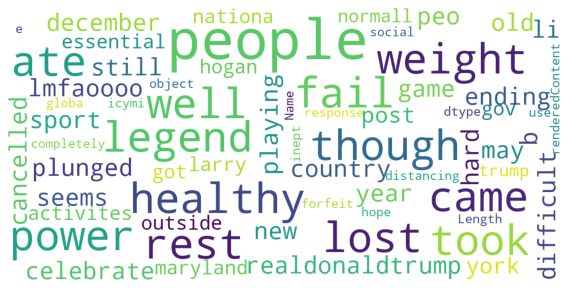

In [8]:
show_wordcloud(df["renderedContent"])

In [5]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [6]:
data = df['renderedContent'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['well', 'lost', 'weight', 'ate', 'healthy', 'fail', 'though', 'came', 'budgeting', 'kind', 'ruined', 'india', 'honest', 'would', 'say', 'healthy', 'every', 'aspect', 'life']


## Building Bi-gram and Tri-gram Models

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [8]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [13]:
data_words_bigrams = make_bigrams(data_words)
data_words_bigrams

[['well',
  'lost',
  'weight',
  'ate',
  'healthy',
  'fail',
  'though',
  'came',
  'budgeting',
  'kind',
  'ruined',
  'india',
  'honest',
  'would',
  'say',
  'healthy',
  'every',
  'aspect',
  'life'],
 ['took', 'legend', 'rest', 'power'],
 ['realdonaldtrump',
  'december',
  'country',
  'plunged',
  'would',
  'become',
  'toughest',
  'battle',
  'even',
  'vaccine',
  'started',
  'go',
  'reported',
  'million',
  'new',
  'infection',
  'death',
  'according',
  'data',
  'compiled',
  'john_hopkins',
  'university'],
 ['seems',
  'hard',
  'celebrate',
  'ending',
  'difficult',
  'year',
  'people',
  'still',
  'dying',
  'around',
  'vaccine',
  'hope',
  'better',
  'end_sight',
  'wishing',
  'safe',
  'healthy',
  'make',
  'best',
  'family',
  'first'],
 ['lmfaoooo', 'like'],
 ['december',
  'black',
  'woman',
  'named',
  'susan_moore',
  'died',
  'white',
  'doctor',
  'named',
  'eric',
  'bannec',
  'indiana',
  'university',
  'health',
  'north',
  'ho

In [9]:
data_words_trigrams = make_trigrams(data_words)
data_words_trigrams

[['well',
  'lost',
  'weight',
  'ate',
  'healthy',
  'fail',
  'though',
  'came',
  'budgeting',
  'kind',
  'ruined',
  'india',
  'honest',
  'would',
  'say',
  'healthy',
  'every',
  'aspect',
  'life'],
 ['took', 'legend', 'rest', 'power'],
 ['realdonaldtrump',
  'december',
  'country',
  'plunged',
  'would',
  'become',
  'toughest',
  'battle',
  'even',
  'vaccine',
  'started',
  'go',
  'reported',
  'million',
  'new',
  'infection',
  'death',
  'according',
  'data',
  'compiled',
  'john_hopkins_university'],
 ['seems',
  'hard',
  'celebrate',
  'ending',
  'difficult',
  'year',
  'people',
  'still',
  'dying',
  'around',
  'vaccine',
  'hope',
  'better',
  'end_sight',
  'wishing',
  'safe',
  'healthy',
  'make',
  'best',
  'family',
  'first'],
 ['lmfaoooo', 'like'],
 ['december',
  'black',
  'woman',
  'named',
  'susan_moore',
  'died',
  'white',
  'doctor',
  'named',
  'eric',
  'bannec',
  'indiana',
  'university',
  'health',
  'north',
  'hospita

## Building rough LDA model 

In [10]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words_trigrams)

# Create Corpus
texts = data_words_trigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]


In [16]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [17]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.019*"death" + 0.015*"amp" + 0.011*"case" + 0.010*"new" + 0.007*"day" + '
  '0.005*"state" + 0.005*"protest" + 0.005*"see_pinned_tweet" + 0.004*"many" + '
  '0.004*"million"'),
 (1,
  '0.024*"trump" + 0.014*"people" + 0.008*"would" + 0.007*"american" + '
  '0.006*"amp" + 0.006*"realdonaldtrump" + 0.006*"like" + 0.005*"president" + '
  '0.005*"say" + 0.005*"get"'),
 (2,
  '0.015*"people" + 0.010*"get" + 0.007*"one" + 0.007*"going" + 0.006*"know" + '
  '0.006*"go" + 0.005*"amp" + 0.005*"still" + 0.005*"trump" + 0.005*"life"'),
 (3,
  '0.010*"pandemic" + 0.010*"amp" + 0.008*"like" + 0.005*"need" + '
  '0.005*"trump" + 0.004*"would" + 0.004*"response" + 0.003*"country" + '
  '0.003*"thing" + 0.003*"crisis"'),
 (4,
  '0.016*"test" + 0.010*"testing" + 0.010*"case" + 0.009*"dc" + 0.009*"day" + '
  '0.008*"get" + 0.007*"positive" + 0.006*"new" + 0.006*"work" + '
  '0.005*"result"')]


In [18]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.402067299881314


## Tuning based on number of topics

In [19]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
       
    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    # Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, 
                                         coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [20]:
# Can take a long time to run. In this case we are going to k_max=14.
import datetime
print(datetime.datetime.now())

from gensim.models import CoherenceModel

coherence_scores = []
model_topics = []

for k in range(2, 20):
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word,k=k) 
    model_topics.append(k)    
    coherence_scores.append(cv)    
    print("#Topics: " + str(k) + ", Score: " + str(coherence_scores[-1]))

print(datetime.datetime.now())

2023-03-15 16:52:32.120163
#Topics: 2, Score: 0.3768626488503221
#Topics: 3, Score: 0.3904887067576037
#Topics: 4, Score: 0.34899821875472725
#Topics: 5, Score: 0.37205720636228756
#Topics: 6, Score: 0.3859395460152921
#Topics: 7, Score: 0.410652581130804
#Topics: 8, Score: 0.40314930273160177
#Topics: 9, Score: 0.39204170974138336
#Topics: 10, Score: 0.3976572187469795
#Topics: 11, Score: 0.3705178184687373
#Topics: 12, Score: 0.38151436711459574
#Topics: 13, Score: 0.3672193851197533
#Topics: 14, Score: 0.33912720751886877
#Topics: 15, Score: 0.3620524480336064
#Topics: 16, Score: 0.38244293513443883
#Topics: 17, Score: 0.3673005508532351
#Topics: 18, Score: 0.37104411234230106
#Topics: 19, Score: 0.37362657576846875
2023-03-15 17:02:26.863502


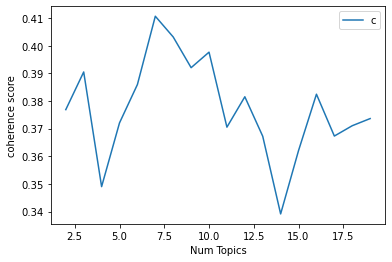

In [21]:
# Show graph

import matplotlib.pyplot as plt

limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence score"), loc='best')
plt.show()

In [22]:
end here

SyntaxError: invalid syntax (<ipython-input-22-9bcc9ab561c7>, line 1)

### Final Model

In [16]:
num_topics = 7

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)

In [17]:
# Save the LDA model

from gensim.test.utils import datapath

lda_model_saved_file = datapath("us_2020_lda_model_7")
lda_model.save(lda_model_saved_file)

In [25]:
score = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
score.get_coherence()

0.4063969724692112

In [26]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./lda_model/washington_normal_2020_lda_vis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './lda_vis/washington_normal_2020_lda_vis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.077540  0.052972       1        1  20.790361
5     -0.089320  0.134882       2        1  19.000962
6      0.259483  0.089808       3        1  13.173604
3     -0.097352  0.091991       4        1  12.414121
4     -0.081468 -0.093071       5        1  12.012837
0     -0.017158 -0.189281       6        1  11.638737
2      0.103356 -0.087302       7        1  10.969377, topic_info=         Term         Freq        Total Category  logprob  loglift
283      test  1467.000000  1467.000000  Default  30.0000  30.0000
28      death  1817.000000  1817.000000  Default  29.0000  29.0000
511      case  1655.000000  1655.000000  Default  28.0000  28.0000
282  positive   708.000000   708.000000  Default  27.0000  27.0000
35        new  1447.000000  1447.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
58      still   122.847987   988.872335   Topic7  -5.8489   0.1244
26    country   112.331026   609.500503   Topic7  -5.9384   0.5189
687     virus   111.048407   705.792409   Topic7  -5.9498   0.3607
136       one   114.731333  1445.762572   Topic7  -5.9172  -0.3237
270        dc   110.183903   891.554345   Topic7  -5.9577   0.1192

[516 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2024      2  0.045305  access
2024      4  0.878909  access
2024      6  0.063426  access
2650      5  0.319955  across
2650      7  0.675461  across
...     ...       ...     ...
60        2  0.419324    year
60        3  0.135633    year
60        4  0.037273    year
60        6  0.073511    year
60        7  0.030026    year

[1145 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 7, 4, 5, 1, 3])

**Added Sentiment Analysis**

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [12]:
def determine_sentiment(score):
    if score < 0:
        return "Negative"
    elif score > 0:
        return "Positive"
    else:
        return "Neutral"

In [13]:
df["renderedContent"] = df['renderedContent'].apply(lambda tweet:str(tweet))
sentiment_scores = df['renderedContent'].apply(sid.polarity_scores)
sentiment_scores

0        {'neg': 0.261, 'neu': 0.323, 'pos': 0.416, 'co...
1        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2        {'neg': 0.281, 'neu': 0.719, 'pos': 0.0, 'comp...
3        {'neg': 0.102, 'neu': 0.341, 'pos': 0.556, 'co...
4        {'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'comp...
                               ...                        
29584    {'neg': 0.163, 'neu': 0.488, 'pos': 0.35, 'com...
29585    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
29586    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
29587    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
29588    {'neg': 0.115, 'neu': 0.656, 'pos': 0.23, 'com...
Name: renderedContent, Length: 29589, dtype: object

In [14]:
# Load the saved model

from gensim.test.utils import datapath
lda_model_saved_file = datapath("us_2020_lda_model_7")
lda_model = gensim.models.ldamodel.LdaModel.load(lda_model_saved_file)

In [15]:
topics, num_topics = [], 7

for i in range(len(corpus)):
    top_topics = (
        lda_model.get_document_topics(corpus[i],
                                      minimum_probability=0.0))
    topic_vec = [top_topics[i][1] for i in range(num_topics)]
    topics.append(topic_vec.index(max(topic_vec))+1)
    
topics

[2,
 6,
 3,
 6,
 4,
 1,
 6,
 5,
 7,
 7,
 1,
 7,
 4,
 1,
 3,
 6,
 7,
 5,
 3,
 2,
 6,
 6,
 6,
 7,
 5,
 2,
 3,
 7,
 7,
 2,
 6,
 6,
 2,
 2,
 2,
 7,
 4,
 4,
 6,
 7,
 6,
 6,
 3,
 5,
 4,
 2,
 2,
 7,
 3,
 6,
 4,
 7,
 6,
 6,
 2,
 5,
 2,
 1,
 4,
 7,
 7,
 6,
 3,
 6,
 6,
 6,
 5,
 7,
 6,
 7,
 1,
 6,
 2,
 3,
 2,
 7,
 1,
 2,
 4,
 6,
 1,
 2,
 1,
 7,
 5,
 2,
 4,
 7,
 5,
 2,
 4,
 2,
 3,
 5,
 5,
 3,
 3,
 2,
 7,
 3,
 1,
 2,
 7,
 3,
 6,
 6,
 1,
 7,
 7,
 5,
 6,
 7,
 7,
 1,
 3,
 6,
 1,
 4,
 2,
 3,
 7,
 1,
 1,
 7,
 5,
 1,
 7,
 3,
 6,
 6,
 3,
 4,
 3,
 2,
 4,
 5,
 5,
 6,
 6,
 3,
 6,
 6,
 2,
 4,
 5,
 7,
 6,
 5,
 3,
 6,
 1,
 4,
 7,
 3,
 4,
 3,
 1,
 1,
 6,
 7,
 1,
 3,
 4,
 6,
 2,
 2,
 2,
 7,
 5,
 2,
 7,
 2,
 7,
 7,
 7,
 4,
 7,
 7,
 6,
 2,
 3,
 2,
 6,
 6,
 4,
 6,
 6,
 6,
 6,
 7,
 5,
 7,
 1,
 6,
 6,
 1,
 5,
 5,
 3,
 2,
 2,
 1,
 7,
 6,
 5,
 6,
 7,
 5,
 2,
 2,
 6,
 5,
 2,
 4,
 7,
 7,
 7,
 2,
 5,
 2,
 2,
 5,
 7,
 7,
 2,
 7,
 2,
 7,
 3,
 3,
 4,
 1,
 3,
 6,
 7,
 7,
 2,
 4,
 3,
 3,
 2,
 7,
 6,
 4,
 6,
 1,
 7,
 7,
 7,
 5,


In [16]:
df["Topic"] = topics
df.head()

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe,Topic
0,https://twitter.com/TeeJ_Apple/status/13447910...,2020-12-31 23:42:28+00:00,well lost weight ate healthy fail though came ...,well lost weight ate healthy fail though came ...,1344791061986762753,https://twitter.com/TeeJ_Apple,1,0,1,0,...,NaN,NaN,"Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN,2
1,https://twitter.com/MattyCj22/status/134478368...,2020-12-31 23:13:10+00:00,took legend rest power,took legend rest power,1344783686659678210,https://twitter.com/MattyCj22,0,0,1,0,...,NaN,NaN,"Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN,6
2,https://twitter.com/aikers99/status/1344779663...,2020-12-31 22:57:11+00:00,realdonaldtrump december country plunged would...,realdonaldtrump december country plunged would...,1344779663852367873,https://twitter.com/aikers99,0,0,0,0,...,https://twitter.com/realDonaldTrump,"[User(username='realDonaldTrump', id=25073877,...","Coordinates(longitude=-77.335163, latitude=38....","Place(id='e4aee3ab11ef52a6', fullName='Fairfax...",NaN,NaN,NaN,NaN,NaN,3
3,https://twitter.com/noramurray/status/13447759...,2020-12-31 22:42:31+00:00,seems hard celebrate ending difficult year peo...,seems hard celebrate ending difficult year peo...,1344775974668423168,https://twitter.com/noramurray,0,0,3,0,...,NaN,NaN,"Coordinates(longitude=-79.487651, latitude=37....","Place(id='dea1eac2d7ef8878', fullName='Marylan...",NaN,NaN,NaN,NaN,NaN,6
4,https://twitter.com/laurvanhasselt/status/1344...,2020-12-31 22:36:59+00:00,lmfaoooo b like,lmfaoooo b like,1344774581995896837,https://twitter.com/laurvanhasselt,1,0,0,0,...,https://twitter.com/ChillWill63,"[User(username='ChillWill63', id=2919643282, d...","Coordinates(longitude=-79.487651, latitude=37....","Place(id='dea1eac2d7ef8878', fullName='Marylan...",NaN,NaN,NaN,NaN,NaN,4


In [17]:
sentiments = sentiment_scores.apply(lambda x: x["compound"])
sentiment_label = sentiments.apply(determine_sentiment)
df["Sentiment"] = sentiment_label
df.head()

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe,Topic,Sentiment
0,https://twitter.com/TeeJ_Apple/status/13447910...,2020-12-31 23:42:28+00:00,well lost weight ate healthy fail though came ...,well lost weight ate healthy fail though came ...,1344791061986762753,https://twitter.com/TeeJ_Apple,1,0,1,0,...,NaN,"Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN,2,Positive
1,https://twitter.com/MattyCj22/status/134478368...,2020-12-31 23:13:10+00:00,took legend rest power,took legend rest power,1344783686659678210,https://twitter.com/MattyCj22,0,0,1,0,...,NaN,"Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN,6,Neutral
2,https://twitter.com/aikers99/status/1344779663...,2020-12-31 22:57:11+00:00,realdonaldtrump december country plunged would...,realdonaldtrump december country plunged would...,1344779663852367873,https://twitter.com/aikers99,0,0,0,0,...,"[User(username='realDonaldTrump', id=25073877,...","Coordinates(longitude=-77.335163, latitude=38....","Place(id='e4aee3ab11ef52a6', fullName='Fairfax...",NaN,NaN,NaN,NaN,NaN,3,Negative
3,https://twitter.com/noramurray/status/13447759...,2020-12-31 22:42:31+00:00,seems hard celebrate ending difficult year peo...,seems hard celebrate ending difficult year peo...,1344775974668423168,https://twitter.com/noramurray,0,0,3,0,...,NaN,"Coordinates(longitude=-79.487651, latitude=37....","Place(id='dea1eac2d7ef8878', fullName='Marylan...",NaN,NaN,NaN,NaN,NaN,6,Positive
4,https://twitter.com/laurvanhasselt/status/1344...,2020-12-31 22:36:59+00:00,lmfaoooo b like,lmfaoooo b like,1344774581995896837,https://twitter.com/laurvanhasselt,1,0,0,0,...,"[User(username='ChillWill63', id=2919643282, d...","Coordinates(longitude=-79.487651, latitude=37....","Place(id='dea1eac2d7ef8878', fullName='Marylan...",NaN,NaN,NaN,NaN,NaN,4,Positive


In [18]:
for content in df[(df["Topic"] == 7) & (df["Sentiment"] == "Negative")].renderedContent:
    print(content)

new  strain dropping midnight
washington dc face year record number murder incident gun violence
realdonaldtrump spent remaining day morally vacant life cell chained wall watching endless loop picture face everyone died  every child locked cage would approach justice
good lost toxic mf unemployment boominnnnnnn worked home rekindled also guapos license car credit card paid degree wait good shit lmaooo fuck  doe
astonishingly high figure uk death recorded past hour 
made cry  death state union patrick stewart reading shall compare thee summer day keep teaching
breaking news u hit record number hospitalization unfortunately record broken amp january arlingtonva alexandriavagov fallschurchgov fairfaxcounty loudouncogovt pwcgop governorva see pinned tweet
holy mary mother god california new death hour death exploding america unfortunately cdcdirector stevefda nihdirector drsanjaygupta jeromeadamsmd billgates melindagates scottgottliebmd bbcnews see pinned tweet
joeflood ebooksyearn kojosho

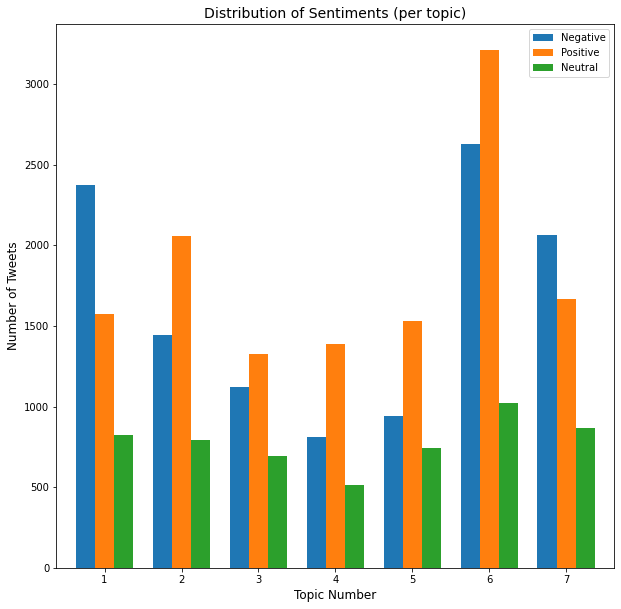

In [19]:
import matplotlib.pyplot as plt

topics = range(1, num_topics+1)
columns = ["Negative", "Positive", "Neutral"]
data = []

for i in range(num_topics):
    curr_topic = df[df["Topic"] == i+1]
    negative, positive, neutral = len(curr_topic[curr_topic["Sentiment"] == "Negative"]), len(curr_topic[curr_topic["Sentiment"] == "Positive"]), len(curr_topic[curr_topic["Sentiment"] == "Neutral"]) 
    data.append([negative, positive, neutral])

topic_sentiment_df = pd.DataFrame(data, columns=columns, index=topics)
topic_sentiment_df.plot(kind="bar", figsize=(10, 10), width=0.75)
plt.title("Distribution of Sentiments (per topic)", fontsize=14)
plt.xlabel("Topic Number", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.gca().xaxis.set_tick_params(rotation=0)
plt.show()